In [ ]:
!nvcc --version

!pip3 install umap
!pip3 install numba
!pip3 install rdkit
!pip3 install hdbscan

In [ ]:
!nvidia-smi --query-gpu=name --format=csv,noheader

In [ ]:
import psutil
import os
 
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))
print(total_memory)


In [ ]:
!nvidia-smi

In [ ]:
import time
import psutil
from matplotlib import pyplot as plt

In [ ]:
import cudf
import pandas as pd

import umap
import numba
import numpy as np
import hdbscan
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs

In [ ]:
isCuda = True
if isCuda:
    from cuml.manifold.umap import UMAP as cuUMAP
    from cuml.cluster import HDBSCAN as cuHDBSCAN
    import cudf
    

In [ ]:
time_start = time.clock()

isCuda = False
if isCuda:
    data = cudf.read_csv("../input/conpountstructure/compoundStructures.csv")
else:
    smiles = pd.read_csv("../input/conpountstructure/compoundStructures.csv")
    data = pd.read_csv("../input/smiles/smiles.csv")

time_elapsed = (time.clock() - time_start)
print("Read Dataset ", time_elapsed )

In [ ]:
print('Shape:', smiles.shape)

In [9]:
smiles

,canonical_smiles
0,CCCc1nc(c(C(=O)O)n1Cc2ccc(cc2)c3ccccc3c4nn[nH]...
1,Oc1c(Br)cc(\C=C\2/C(=O)Nc3ccc(I)cc23)cc1Br
2,CN(CCO\C(=C/1\C(C(=C(C)N=C1CSc2ccccc2)C#N)c3cc...
3,CCOC(=O)C1=C(CSc2ccccc2)N(C)C(=C(C#N)C1c3ccccc...
4,C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NC2CCCCC2...
...,...
99995,CCCOCC1CNc2nc(N)nc(O)c2N1
99996,CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)NCCc1ccc(O)c(O)c1
99997,CC(C)CCCC(C)C1CCC2C3[C@@H](C)CC(=O)[C@](C)(C[C...
99998,COc1ccc(CCNC(=O)C2(C)CCc3c(C)c(O)c(C)c(C)c3O2)...


In [10]:
smiles

,canonical_smiles
0,CCCc1nc(c(C(=O)O)n1Cc2ccc(cc2)c3ccccc3c4nn[nH]...
1,Oc1c(Br)cc(\C=C\2/C(=O)Nc3ccc(I)cc23)cc1Br
2,CN(CCO\C(=C/1\C(C(=C(C)N=C1CSc2ccccc2)C#N)c3cc...
3,CCOC(=O)C1=C(CSc2ccccc2)N(C)C(=C(C#N)C1c3ccccc...
4,C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NC2CCCCC2...
...,...
99995,CCCOCC1CNc2nc(N)nc(O)c2N1
99996,CC\C=C/C\C=C/C\C=C/CCCCCCCC(=O)NCCc1ccc(O)c(O)c1
99997,CC(C)CCCC(C)C1CCC2C3[C@@H](C)CC(=O)[C@](C)(C[C...
99998,COc1ccc(CCNC(=O)C2(C)CCc3c(C)c(O)c(C)c(C)c3O2)...


In [11]:
time_start = time.clock()
#run your code
smiles['mol'] = smiles.apply(lambda mol: Chem.MolFromSmiles(mol['canonical_smiles']), axis=1)
mols = [Chem.MolFromSmiles(mol) for mol in smiles]
mols = [mol for mol in mols if mol is not None]
for mol in mols:AllChem.Compute2DCoords(mol)
time_elapsed = (time.clock() - time_start)

print("Compute Compute2DCoords ", time_elapsed )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Compute Compute2DCoords  23.369452000000003


[17:56:37] SMILES Parse Error: syntax error while parsing: canonical_smiles
[17:56:37] SMILES Parse Error: Failed parsing SMILES 'canonical_smiles' for input: 'canonical_smiles'
[17:56:37] SMILES Parse Error: syntax error while parsing: mol
[17:56:37] SMILES Parse Error: Failed parsing SMILES 'mol' for input: 'mol'
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [12]:
AllChem

<module 'rdkit.Chem.AllChem' from '/opt/conda/lib/python3.7/site-packages/rdkit/Chem/AllChem.py'>

In [13]:
time_start = time.clock()

X = []
for mol in smiles['mol'].values:
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)
time_elapsed = (time.clock() - time_start)

print("Prepare X ", time_elapsed )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Prepare X  15.105856


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == "__main__":


In [14]:
@numba.njit()
def tanimoto_dist(a, b):
    dotprod = np.dot(a, b)
    tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
    return 1.0 - tc

In [15]:
%time
start = time.time()
umap_X = cuUMAP(n_neighbors=10, min_dist=0.1)
umap_X = umap_X.fit_transform(np.array(X))
end = time.time()
umap_duration = end - start

start = time.time()

cluster_umap = cuHDBSCAN(min_cluster_size=3, gen_min_span_tree=True)
cluster_umap.fit(umap_X)
end = time.time()
clustering_duration = end - start
print("Umap Duration :", umap_duration)
print("Clustering Duration :", clustering_duration)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs
Label prop iterations: 18
Label prop iterations: 8
Label prop iterations: 7
Label prop iterations: 8
Label prop iterations: 2
Iterations: 5
4789,148,1427,21,259,1419
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
4315,143,1097,19,260,838
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 5
Iterations: 4
4453,120,912,17,216,791
Label prop iterations: 3
Label prop iterations: 2
Iterations: 2
4161,76,546,10,108,218
Umap Duration : 13.07152533531189
Clustering Duration : 3.068373441696167


In [16]:
print("Umap Time", umap_duration)
print("Clustering Time", clustering_duration)

Umap Time 13.07152533531189
Clustering Time 3.068373441696167


In [17]:
!nvidia-smi

Sun Oct  9 17:57:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    39W / 250W |   1581MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

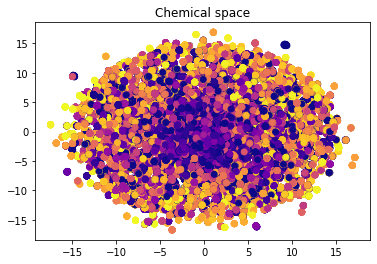

In [18]:
plt.figure()
plt.scatter(umap_X.T[0], umap_X.T[1], c=cluster_umap.labels_, cmap='plasma')
plt.title('Chemical space')
plt.show()

/opt/conda/lib/python3.7/site-packages/hdbscan/plots.py:818: UserWarning: Too many data points for safe rendering of an minimal spanning tree!
  warn('Too many data points for safe rendering of an minimal spanning tree!')


<Figure size 432x288 with 0 Axes>

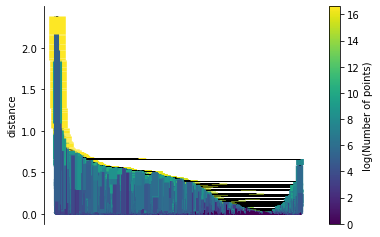

In [19]:
plt.figure(0)
cluster_umap.minimum_spanning_tree_.plot(
    edge_cmap='viridis', edge_alpha=0.6,
    node_size=90, edge_linewidth=2)

plt.figure(1)
cluster_umap.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

In [20]:
!pip3 install umap-learn
!pip3 install umap

In [21]:
import umap.umap_ as umap
#import umap

In [ ]:
%time
start = time.time()
umap_X = umap.UMAP(n_neighbors=5, min_dist=0.3, metric=tanimoto_dist).fit_transform(X)
end = time.time()
umap_duration =  end-start
start = time.time()
cluster_umap = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
cluster_umap.fit(umap_X)
end = time.time()
clustering_duration = end - start


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/opt/conda/lib/python3.7/site-packages/umap/umap_.py:1773: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


In [ ]:
print("Umap Time", umap_duration)
print("Clustering Time", clustering_duration)

In [ ]:
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))
print(total_memory)
print('The CPU usage is: ', psutil.cpu_percent(4))


In [ ]:
plt.figure()
plt.scatter(umap_X.T[0], umap_X.T[1], c=cluster_umap.labels_, cmap='plasma')
plt.title('Chemical space')
plt.show()

In [ ]:
print("Umap Time", umap_duration)
print("Clustering Time", clustering_duration)